In [14]:
using Dates
using MarketData
using StatsBase
using Plots
using DataFrames
using Statistics
using MarketTechnicals
include("Chapter 14 Snippets.jl")
include("HHI.jl")

HHI (generic function with 1 method)

# Data
We import bitcoin data from Yahoo finance from 2021.

In [2]:
btc = yahoo("BTC-USD", YahooOpt(period1 = DateTime(2021, 1, 1), period2 = DateTime(2021, 12, 1)))["Close"]

335×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2021-01-01 to 2021-12-01
│            │ Close      │
├────────────┼────────────┤
│ 2021-01-01 │ 29374.1523 │
│ 2021-01-02 │ 32127.2676 │
│ 2021-01-03 │ 32782.0234 │
│ 2021-01-04 │ 31971.9141 │
│ 2021-01-05 │ 33992.4297 │
│ 2021-01-06 │ 36824.3633 │
│ 2021-01-07 │ 39371.043  │
│ 2021-01-08 │ 40797.6094 │
│ 2021-01-09 │ 40254.5469 │
   ⋮
│ 2021-11-24 │ 56280.4258 │
│ 2021-11-25 │ 57274.6797 │
│ 2021-11-26 │ 53569.7656 │
│ 2021-11-27 │ 54815.0781 │
│ 2021-11-28 │ 57248.457  │
│ 2021-11-29 │ 57806.5664 │
│ 2021-11-30 │ 57005.4258 │
│ 2021-12-01 │ 57229.8281 │

In [3]:
using MarketTechnicals
btc_df = DataFrame(btc[55:end])
btc_df[!, "Expected 55"] = ema(values(btc), 55)[1:end]
btc_df[!, "Expected 15"] = ema(values(btc), 15)[55 - 15 + 1: end]
btc_df[!, :Cross] .= 0
btc_df[!, :Cross] = ifelse.(btc_df[:, "Expected 55"] .< btc_df[:, "Expected 15"], 1, 0)
btc_df[!, :Signal] = [0; diff(btc_df.Cross)]
btc_df = btc_df[2:end, :]
btc_df[!, :Return] = values(percentchange(btc[55:end]))
btc_ts = TimeArray(btc_df, timestamp = :timestamp)

280×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2021-02-25 to 2021-12-01
│            │ Close      │ Expected 55 │ Expected 15 │ Cross │ Signal │
├────────────┼────────────┼─────────────┼─────────────┼───────┼────────┤
│ 2021-02-25 │ 47093.8516 │ 40068.2385  │ 49537.9107  │ 1.0   │ 0.0    │
│ 2021-02-26 │ 46339.7617 │ 40292.2215  │ 49138.1421  │ 1.0   │ 0.0    │
│ 2021-02-27 │ 46188.4531 │ 40502.8012  │ 48769.431   │ 1.0   │ 0.0    │
│ 2021-02-28 │ 45137.7695 │ 40668.3358  │ 48315.4733  │ 1.0   │ 0.0    │
│ 2021-03-01 │ 49631.2422 │ 40988.4396  │ 48479.9444  │ 1.0   │ 0.0    │
│ 2021-03-02 │ 48378.9883 │ 41252.3877  │ 48467.3249  │ 1.0   │ 0.0    │
│ 2021-03-03 │ 50538.2422 │ 41584.0254  │ 48726.1896  │ 1.0   │ 0.0    │
│ 2021-03-04 │ 48561.168  │ 41833.2091  │ 48705.5619  │ 1.0   │ 0.0    │
│ 2021-03-05 │ 48927.3047 │ 42086.5696  │ 48733.2797  │ 1.0   │ 0.0    │
   ⋮
│ 2021-11-24 │ 56280.4258 │ 58342.0238  │ 59658.0335  │ 1.0   │ 0.0    │
│ 2021-11-25 │ 57274.6797 │ 58303.9044  │ 5

In [4]:
targetPositions = btc_ts.Cross
returns = btc_ts.Return
print()

# Bet timing
We derive the bet timing when positions flatten or flip.

In [5]:
betTiming(targetPositions)

4-element Vector{Date}:
 2021-05-13
 2021-09-26
 2021-11-30
 2021-12-01

# Holding Period 
Derives avgerage holding period (in days) using avg entry time pairing algo

In [6]:
holding, mean = holdingPeriod(targetPositions)
holding

3×2 TimeArray{Float64, 2, Date, Matrix{Float64}} 2021-05-13 to 2021-11-30
│            │ dT    │ w     │
├────────────┼───────┼───────┤
│ 2021-05-13 │ 77.0  │ 1.0   │
│ 2021-09-26 │ 58.0  │ 1.0   │
│ 2021-11-30 │ 58.0  │ 1.0   │

In [7]:
mean

64.33333333333333

#  HHI concentration
Derives the algorithm for deriving hhi concentration

In [8]:
positiveReturnsConcentration, negativeReturnsConcentration, 
        monthlyReturnsConcentration = HHIConcentration(returns)

(0.005233561373351348, 0.006029499264795563, 0.018165816326530592)

# Compute Draw Downs And Time Under Water
Computes series of drawdowns and the time under water associated with them

In [30]:
drawDowns, timeUnderWater, drawdownAnalysis = computeDrawDownsTimeUnderWater(btc, true)
drawDowns

12×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2021-01-03 to 2021-11-08
│            │ drawDowns  │
├────────────┼────────────┤
│ 2021-01-03 │ 810.1094   │
│ 2021-01-08 │ 10365.0625 │
│ 2021-02-09 │ 1562.9219  │
│ 2021-02-11 │ 803.8164   │
│ 2021-02-14 │ 772.2305   │
│ 2021-02-17 │ 469.2109   │
│ 2021-02-21 │ 12402.1758 │
│ 2021-03-11 │ 473.0312   │
│ 2021-03-13 │ 9538.9258  │
│ 2021-04-13 │ 33696.1094 │
│ 2021-10-20 │ 7510.4492  │
│ 2021-11-08 │ 13997.0625 │

In [16]:
timeUnderWater

12×1 TimeArray{Float64, 1, Date, Vector{Float64}} 2021-01-03 to 2021-11-08
│            │ timeUnderWater │
├────────────┼────────────────┤
│ 2021-01-03 │ 0.0027         │
│ 2021-01-08 │ 0.0822         │
│ 2021-02-09 │ 0.0027         │
│ 2021-02-11 │ 0.0055         │
│ 2021-02-14 │ 0.0027         │
│ 2021-02-17 │ 0.0027         │
│ 2021-02-21 │ 0.0466         │
│ 2021-03-11 │ 0.0027         │
│ 2021-03-13 │ 0.0822         │
│ 2021-04-13 │ 0.5151         │
│ 2021-10-20 │ 0.0493         │
│ 2021-11-08 │ 0.063          │

In [17]:
drawdownAnalysis

Row,Start,Stop,HWM,Min,Min. Time
,Date,Date,Float64,Float64,Date
1,2021-01-03,2021-01-04,32782.0,31971.9,2021-01-04
2,2021-01-08,2021-02-07,40797.6,30432.5,2021-01-27
3,2021-02-09,2021-02-10,46481.1,44918.2,2021-02-10
4,2021-02-11,2021-02-13,47909.3,47105.5,2021-02-13
5,2021-02-14,2021-02-15,48717.3,47945.1,2021-02-15
6,2021-02-17,2021-02-18,52149.0,51679.8,2021-02-18
7,2021-02-21,2021-03-10,57539.9,45137.8,2021-02-28
8,2021-03-11,2021-03-12,57805.1,57332.1,2021-03-12
9,2021-03-13,2021-04-12,61243.1,51704.2,2021-03-25


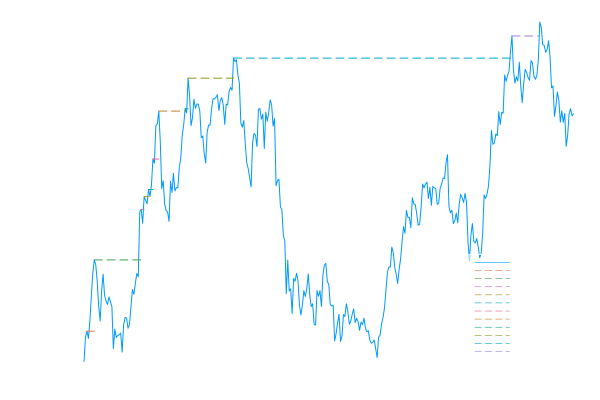

In [18]:
p = plot(btc, label = "BTC", background = :transparent, 
        legend = :bottomright, legendfont=font(5), legendfontcolor = :white) 
for i in 1:length(drawDowns)-1
    plot!(p, [timestamp(drawDowns)[i]; timestamp(drawDowns)[i+1]], [values(btc[timestamp(drawDowns)])[i]; values(btc[timestamp(drawDowns)])[i]], label = "Drawdown $i", linestyle=:dash, 
            background = :transparent, legendfontcolor = :white)
end
display(p) # 